Transformer model training

import libraries

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


loading preprocessed dataset

In [3]:
file_path = "preprocessed_dataset.csv"  # Update this path
data = pd.read_csv(file_path)

defining features and target

In [4]:
features = ['PM2.5', 'O3', 'TEMPERATURE', 'PRESSURE', 'DEWPOINT', 'RAIN']
target = 'PM2.5'

splitting features and target

In [5]:
X = data[features].values
y = data[target].values

min max normalization

In [6]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

define timesteps

In [7]:
timesteps = 24

creating sliding windows

In [8]:
def create_sliding_window(data, labels, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i+timesteps])
        y.append(labels[i+timesteps])
    return np.array(X), np.array(y)

create sliding windows

In [9]:
X, y = create_sliding_window(X_scaled, y, timesteps)


splitting data tinro training and testing datasets

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


shapes printing

In [11]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (6090, 24, 6)
X_test shape: (1523, 24, 6)


defining transformer model

In [12]:
def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_layers, dropout=0.2):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs

    for _ in range(num_layers):
        # Multi-head attention
        x = tf.keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
        x = tf.keras.layers.Dropout(dropout)(x)
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

        # Feed-forward network
        x_ff = tf.keras.layers.Dense(ff_dim, activation="relu")(x)
        x_ff = tf.keras.layers.Dropout(dropout)(x_ff)
        x_ff = tf.keras.layers.Dense(input_shape[-1])(x_ff)

        # Residual connection
        x = tf.keras.layers.Add()([x, x_ff])
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

    # Global average pooling and output layer
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = tf.keras.layers.Dense(1, activation="linear")(x)

    return tf.keras.Model(inputs, outputs)

model hyperparameters

In [13]:
input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)
head_size = 64  # Attention head size
num_heads = 4   # Number of attention heads
ff_dim = 128    # Feed-forward layer size
num_layers = 2  # Number of Transformer blocks
dropout = 0.2   # Dropout rate

building model

In [14]:
transformer_model = build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_layers, dropout)
transformer_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
transformer_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 24, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 6)     │      6,918 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 24, 6)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 24, 6)     │         12 │ dropout_1[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 24, 128)   │        896 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 24, 128)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 24, 6)     │        774 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 24, 6)     │          0 │ layer_normalizat… │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 6)     │         12 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 6)     │      6,918 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 24, 6)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 6)     │         12 │ dropout_4[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 24, 128)   │        896 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 24, 128)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 24, 6)     │        774 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 24, 6)     │          0 │ layer_normalizat… │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 6)     │         12 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 6)         │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │          7 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,231 (67.31 KB)

 Trainable params: 17,231 (67.31 KB)

 Non-trainable params: 0 (0.00 B)

training model

In [15]:
# Train the model
history = transformer_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=8,
    verbose=1
)


Epoch 1/50
762/762 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0137 - mae: 0.0630 - val_loss: 0.0014 - val_mae: 0.0242
Epoch 2/50
762/762 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0020 - mae: 0.0262 - val_loss: 0.0018 - val_mae: 0.0326
Epoch 3/50
762/762 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0022 - mae: 0.0264 - val_loss: 0.0012 - val_mae: 0.0212
Epoch 4/50
762/762 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.0015 - mae: 0.0212 - val_loss: 0.0012 - val_mae: 0.0190
Epoch 5/50
762/762 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.0018 - mae: 0.0213 - val_loss: 0.0014 - val_mae: 0.0256
Epoch 6/50
762/762 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.0022 - mae: 0.0217 - val_loss: 0.0012 - val_mae: 0.0211
Epoch 7/50
762/762 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.0019 - mae: 0.0205 - val_loss: 0.0011 - val_mae: 0.0187
Epoch 8/50
762/762 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - loss: 0.0018 - mae: 0.0205 - val_loss: 0.0011 - val_mae: 0.0175
Epoch 9/50
762/762 ━━━━━━━━━━━━━━━━━━━━ 20s 1

evaluating model

In [16]:
# Evaluate the model on the test set
loss, mae = transformer_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss}, Test MAE: {mae}")

Test Loss: 0.0010229697218164802, Test MAE: 0.017107458785176277


plotting results

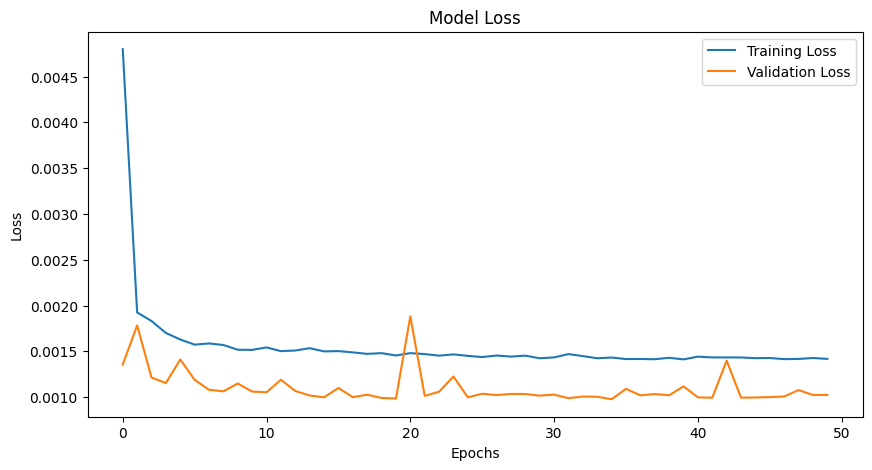

In [17]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


forecasting

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


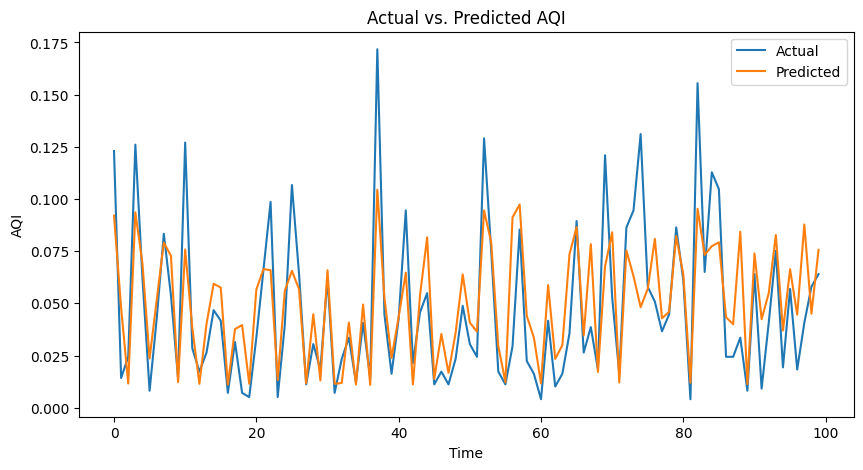

In [18]:
# Predict on test data
y_pred = transformer_model.predict(X_test)

# Visualize actual vs. predicted
plt.figure(figsize=(10, 5))
plt.plot(y_test[:100], label='Actual')
plt.plot(y_pred[:100], label='Predicted')
plt.title('Actual vs. Predicted AQI')
plt.xlabel('Time')
plt.ylabel('AQI')
plt.legend()
plt.show()


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Assuming y_test are actual values and y_pred are model predictions
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)


Mean Absolute Error (MAE): 0.01710746054929452
Root Mean Squared Error (RMSE): 0.03198389602925377
R² Score: 0.43606094812339047
